In [259]:
from __future__ import print_function, division
import os
import torch
from torch.optim.optimizer import Optimizer
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
import torch.nn as nn
import torch.nn.functional as F

from skimage.color import rgb2gray

from torch.utils.tensorboard import SummaryWriter

import PIL
from PIL import Image

from keras.datasets import mnist

from google.colab import output

In [260]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [261]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


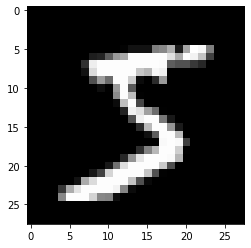

Label: 5
Flatten size: 784


In [262]:
pyplot.imshow(train_X[0], cmap=pyplot.get_cmap('gray'))
pyplot.show()

print("Label: {}".format(train_y[0]))
print("Flatten size: {}".format(len(train_X[0].flatten())))

In [263]:
%mkdir results

mkdir: cannot create directory ‘results’: File exists


In [264]:
!git clone https://github.com/PauliusMilmantas/Bakalaurinis_darbas

fatal: destination path 'Bakalaurinis_darbas' already exists and is not an empty directory.


In [265]:
%cd /content/Bakalaurinis_darbas/Code

/content/Bakalaurinis_darbas/Code


In [266]:
def get_answer(output):
  if output[0] > output[1]:
    return 0
  else:
    return 1

In [267]:
import pandas as pd

class ORCDataset(Dataset):
  def __init__(self, root):
    self.root = root
    self.data = pd.read_csv(root)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    dat = {}
    dat['Pregnancies'] = self.data['Pregnancies'][idx]
    dat['Glucose'] = self.data['Glucose'][idx]
    dat['BloodPressure'] = self.data['BloodPressure'][idx]
    dat['BMI'] = self.data['BMI'][idx]
    dat['Age'] = self.data['Age'][idx]
    found_type = self.data['Outcome'][idx]

    return {'data': dat, 'class_name': found_type}

class MNISTDataset(Dataset):
  def __init__(self, root):
    self.root = root
    self.data = { "train_X": train_X, "train_y": train_y, "test_X": test_X, "test_y": test_y }

  def __len__(self):
    if self.root == 'test':
      return len(self.data["test_X"])
    else:
      return len(self.data["train_X"])

  def __getitem__(self, idx):
    if self.root == 'test':
      return {'data': test_X[idx], 'class_name': test_y[idx]}
    else:
      return {'data': train_X[idx], 'class_name': train_y[idx]}

train_dataset = MNISTDataset('test')
test_dataset = MNISTDataset('train')

In [268]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)        
        out = self.relu2(out)     
        out = self.fc3(out)
        return out

2 <- 7 <- 15 <- 5

In [269]:
network = Net(784, 394, 196, 10)
optimizer = torch.optim.SGD(network.parameters(), lr=0.0001, momentum=0.6)
criterion = nn.MSELoss().cuda()

print(network)

Net(
  (fc1): Linear(in_features=784, out_features=394, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=394, out_features=196, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=196, out_features=10, bias=True)
)


In [270]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
network.to(dev)
criterion.to(dev)
dev

device(type='cpu')

In [271]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [272]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = len(train_dataset),shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset),shuffle=True)

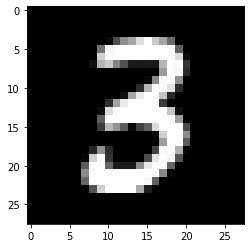

tensor(3, dtype=torch.uint8)


In [273]:
dataiter = iter(train_loader)
itr = dataiter.next()

label = itr['class_name']
dat = itr['data']

pyplot.imshow(dat[0], cmap=pyplot.get_cmap('gray'))
pyplot.show()

print(label[0])

In [276]:
def train(train_loader, test_loader, epoch_amount, save_checkpoint = 10):
  network.eval()
  train_loss_hist = []
  acc_history = []

  checkpoint = save_checkpoint
  for epoch in range(epoch_amount):
    num_data_train = 0

    # TRAINING DATASET
    correct = 0
    wrong = 0
    for data in train_loader:
      labels = torch.from_numpy(np.array(data['class_name']))
      dat = data['data']

      lossSum = 0

      parsedData = []
      '''
      for dictIdx in range(len(labels)):
        parsedData.append(
            np.array([dat['Pregnancies'][dictIdx].float(), dat['Glucose'][dictIdx].float(), dat['BloodPressure'][dictIdx].float(), dat['BMI'][dictIdx].float(), dat['Age'][dictIdx].float()])
            )
      '''

      for idx in range(len(labels)):
        optimizer.zero_grad()
        
        outputs = network(torch.Tensor(dat[idx].flatten().float()))
        realAnswer = np.zeros(10)
        realAnswer[labels[idx]] = 1

        loss = criterion(outputs, torch.Tensor(realAnswer))
          
        loss.backward()

        lossSum += loss.item()
        train_loss_hist.append(lossSum)

        optimizer.step()
    '''
    # TESTING DATASET
    for data in test_loader:
      labels = torch.from_numpy(np.array(data['class_name']))
      dat = data['data']

      for idx in range(len(labels)):
        outputs = network(torch.Tensor(dat[idx].flatten().float()))

        predicted = get_answer(outputs)
        real_answer = labels[idx].item()

        if predicted == real_answer:
          correct += 1
        else:
          wrong += 1

    acc_history.append(
        correct/(correct+wrong)*100
    )
    '''
    #print("Epoch: {} Training loss: {} Accuracy: {}".format(epoch,train_loss_hist[len(train_loss_hist) - 1], acc_history[len(acc_history) - 1]))
    print("Epoch: {} Training loss: {}".format(epoch,train_loss_hist[len(train_loss_hist) - 1]))

    if(checkpoint == 0):
      torch.save(network.state_dict(), '/content/results/model.pth')
      torch.save(optimizer.state_dict(), '/content/results/optimizer.pth')

      checkpoint = save_checkpoint
    else:
      checkpoint -= 1

  plt.plot(np.arange(0, len(train_loss_hist), 1), train_loss_hist)
  plt.show()

  plt.plot(np.arange(0, len(acc_history), 1), acc_history)
  plt.show()

  avg_hist = []

  for i in range(int(len(acc_history)/10)):
    avg = 0
    
    for p in range(10):
      avg += acc_history[i*10 + p]

    avg_hist.append(avg/10)

  plt.plot(np.arange(0, len(avg_hist)), avg_hist)
  plt.grid()
  plt.show()

train(train_loader, test_loader, 20)


Epoch: 0 Training loss: 866.0762541648
Epoch: 1 Training loss: 813.7256100410304
Epoch: 2 Training loss: 779.2987110129034


KeyboardInterrupt: ignored

Palieka tik tie duomenys iš training_set, kurie yra teisingai atsakyti

In [ ]:
increaseValues = [0, 0, 0, 0, 0]
dataIdx = [0, 0, 0, 0, 0]

for data in train_loader:
      labels = torch.from_numpy(np.array(data['class_name']))
      dat = data['data']

      parsedData = []
      for dictIdx in range(len(labels)):
        parsedData.append(
            np.array([dat['Pregnancies'][dictIdx].float(), dat['Glucose'][dictIdx].float(), dat['BloodPressure'][dictIdx].float(), dat['BMI'][dictIdx].float(), dat['Age'][dictIdx].float()])
            )

      for idx in range(len(labels)):
        outputs = network(torch.Tensor(parsedData[idx].flatten()))
        
        predicted = get_answer(outputs)
        real_answer = labels[idx].item()

        collumnIdx = 0
        for collumnIdx in range(5):

          # Sutampa duomenys, vykdoma tolimesne analize
          if(predicted == real_answer):
            epsilon = 0.1
            increase = 0
            dataIdx[collumnIdx] += 1

            while(predicted == real_answer and increase < 100):
              tempData = parsedData[idx].flatten()
              increase += epsilon
              tempData[0] += increase

              outputs = network(torch.Tensor(tempData))

              predicted = get_answer(outputs)
              real_answer = labels[idx].item()

            increaseValues[collumnIdx] += increase

for i in range(5):
  if dataIdx[i] == 0:
    dataIdx[i] = 1

  print("{}th collumn maximum epsilon: {}".format(i, increaseValues[i]/dataIdx[i]))

s = 0
for i in range(5):
  s += increaseValues[i]/dataIdx[i]

print("Model maximum epsilon: {}".format(s/5))